In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Climate Analysis

In [8]:

inspector.get_columns('Station')
session.query(Station.station).all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [9]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
lDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
bDate = dt.datetime.strptime(lDate[0],"%Y-%m-%d") - dt.timedelta(days=365)
# Perform a query to retrieve the date and precipitation scores
prcp_date = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= bDate).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prDf = pd.DataFrame(prcp_date)
prDf_clean = prDf.dropna()
# Sort the dataframe by date
prDf_clean['date'] = pd.to_datetime(prDf_clean['date'])

C:\Users\norfe\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Text(0, 0.5, 'Perceptation (inches?)')

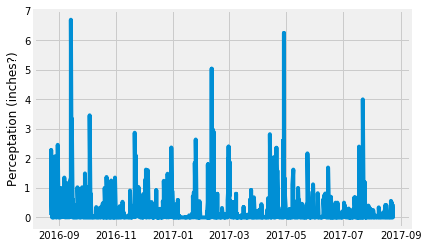

In [10]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(prDf_clean['date'],prDf_clean['prcp'])
plt.ylabel('Perceptation (inches?)')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prDf_clean.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()


9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(0)).group_by(Measurement.station).order_by(func.count(0).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
station_with_mostest = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(0).desc()).first()
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
print(f'Max temp at station {station_with_mostest[0]} is {session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_with_mostest[0]).first()[0]}')
print(f'Min temp at station {station_with_mostest[0]} is {session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_with_mostest[0]).first()[0]}')
print(f'Average temp at station {station_with_mostest[0]} is {session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_with_mostest[0]).first()[0]}')

Max temp at station USC00519281 is 85.0
Min temp at station USC00519281 is 54.0
Average temp at station USC00519281 is 71.66378066378067


In [15]:
# Choose the station with the highest number of temperature observations.
station_with_mostest[0]

'USC00519281'

In [16]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tops_date_mostest = session.query(Measurement.tobs).filter(Measurement.date >= bDate).filter(Measurement.station == station_with_mostest[0]).order_by(Measurement.date).all()

Text(0.5, 1.0, 'Temperatures of Oahu')

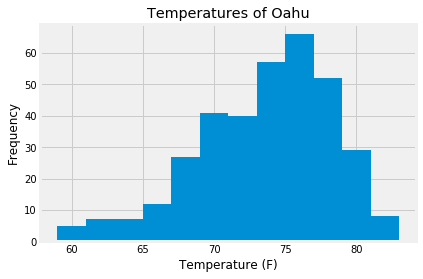

In [17]:
tempDf = pd.DataFrame(tops_date_mostest)
#help(plt.h[ist)
#tempDf['tobs']
temp_hist = plt.hist(tempDf['tobs'],bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperatures of Oahu')

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip usi6ng the previous year's data for those same dates.
t = (calc_temps('2016-01-01', '2017-01-01'))[0]
t


(56.0, 74.1317494600432, 84.0)

([<matplotlib.axis.XTick at 0x2404e7cef28>],
 <a list of 1 Text xticklabel objects>)

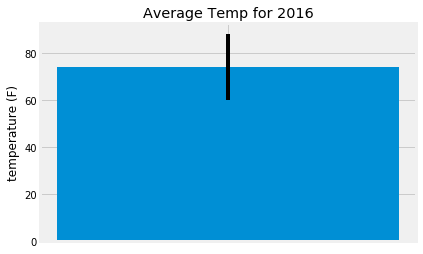

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(0,t[1],yerr= (t[2]-t[0])/2)
plt.title('Average Temp for 2016')
plt.ylabel('temperature (F)')
plt.xticks([0],[''])

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
